In [1]:
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start=start, end=end)['Close']
    log_returns = np.log(stockData) - np.log(stockData.shift(1))
    covMatrix = log_returns.cov()
    corMatrix = log_returns.corr()
    return stockData, log_returns, covMatrix, corMatrix

In [3]:
indices = ['^GSPC', '^IXIC']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=5000)
prices, log_returns, covMatrix, corMatrix = get_data(indices, startDate, endDate)
prices['diff'] = prices['^IXIC'] - prices['^GSPC']


[*********************100%***********************]  2 of 2 completed


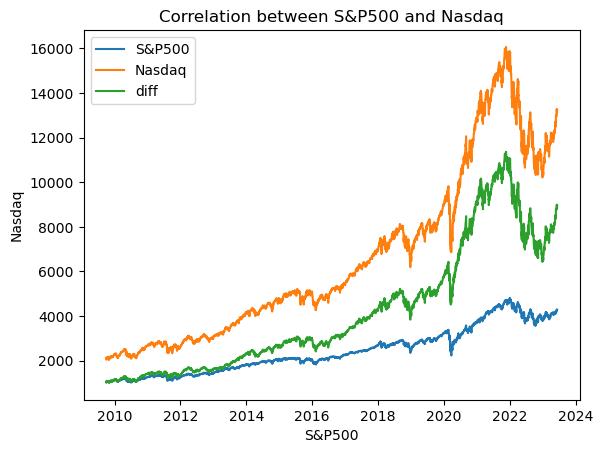

In [4]:
plt.plot(prices)
plt.title('Correlation between S&P500 and Nasdaq')
plt.xlabel('S&P500')
plt.ylabel('Nasdaq')
plt.legend(['S&P500', 'Nasdaq', 'diff'])
plt.show()

In [5]:
print('stats\n',prices.describe(), '\n\nlast price diff',prices['diff'][-1])

df = prices['diff']
normalized_df=(df-df.mean())/df.std()
# to use min-max normalization:
mm_normalized_df=(df-df.min())/(df.max()-df.min())

stats
              ^GSPC         ^IXIC          diff
count  3446.000000   3446.000000   3446.000000
mean   2429.348975   6571.040496   4141.691521
std    1023.889201   3792.099655   2782.878579
min    1022.580017   2045.109985   1006.319946
25%    1540.207520   3204.062561   1687.887543
50%    2139.169922   5162.655029   3039.915039
75%    3006.727478   8530.952881   5460.045044
max    4796.560059  16057.440430  11359.480469 

last price diff 8942.5009765625


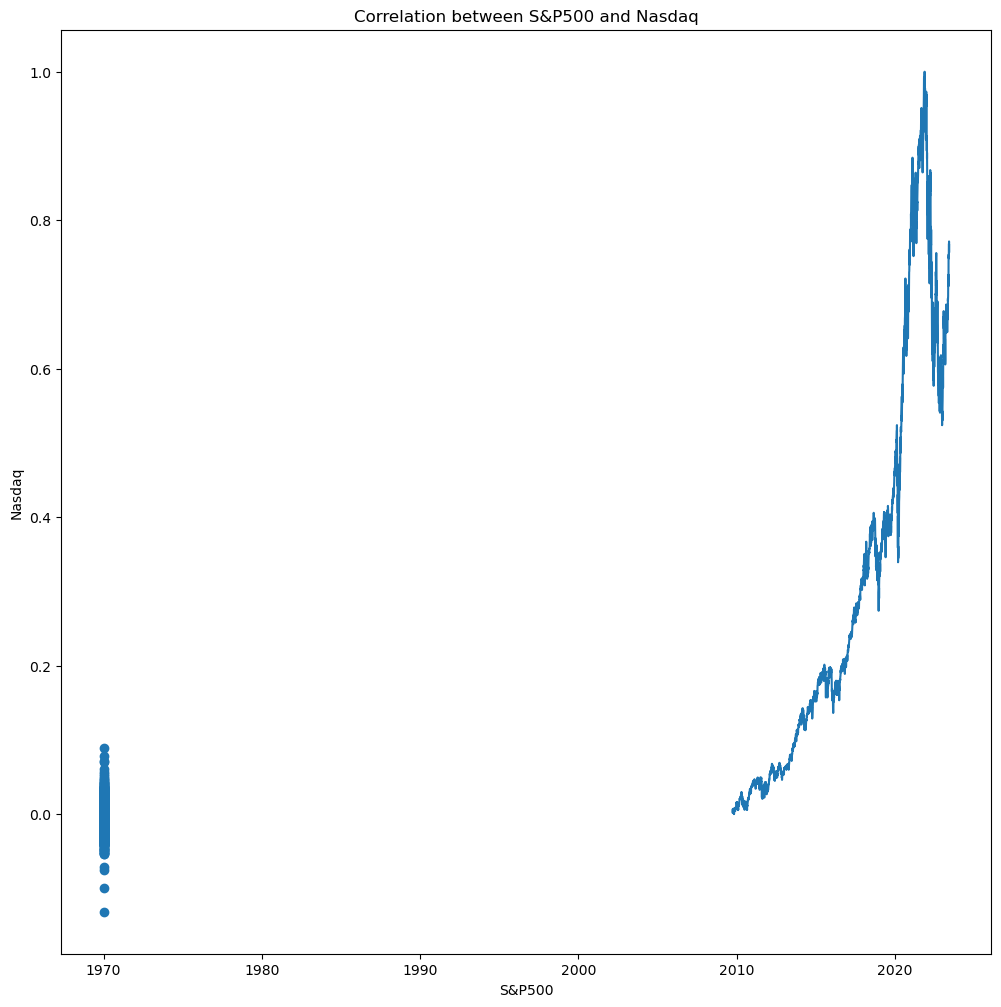

Index Correlation:            ^GSPC     ^IXIC
^GSPC  1.000000  0.950384
^IXIC  0.950384  1.000000
Index Covariance to Volatility:            ^GSPC     ^IXIC
^GSPC  0.177551  0.186311
^IXIC  0.186311  0.205710
Index Volatility:  ^GSPC    0.177525
^IXIC    0.205680
dtype: float64


In [6]:
plt.figure(figsize=(12,12))
plt.plot(mm_normalized_df)

plt.scatter(log_returns['^GSPC'], log_returns['^IXIC'])
plt.title('Correlation between S&P500 and Nasdaq')
plt.xlabel('S&P500')
plt.ylabel('Nasdaq')
plt.show()
print('Index Correlation: ', corMatrix)
print('Index Covariance to Volatility: ', np.sqrt(covMatrix)*np.sqrt(252))
print('Index Volatility: ', np.std(log_returns)*np.sqrt(252))


In [7]:
# Parameters
SP500 = 4373.94
NASD =     13751.40
div_SP500 = 0.0127
div_NASD = 0.0126
vol_SP500 = 0.143050
vol_NASD = 0.194692
K = 9377 # current difference between index points 
T = 1
r = 0.01828 # 10yr US Treasury Bond
rho = 0.922323 # correlation
N = 1 # discrete time steps
M = 1000 # number of simulations

In [8]:
N=100
dt = T/N
S1 = NASD
S2 = SP500
nu1dt = (r - div_NASD - 0.5*vol_NASD**2)*dt
nu2dt = (r - div_SP500 - 0.5*vol_SP500**2)*dt
vol1sdt = vol_NASD*np.sqrt(dt)
vol2sdt = vol_SP500*np.sqrt(dt)
srho = np.sqrt(1-rho**2)

# Monte Carlo Method
dz1 = np.random.normal(size=(N, M)) 
dz2 = np.random.normal(size=(N, M)) 
Z1 = dz1
Z2 = rho*dz1 + srho*dz2
delta_St1 = nu1dt + vol1sdt*Z1
delta_St2 = nu2dt + vol2sdt*Z2
ST1 = S1*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S2*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S1), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S2), ST2 ) )

CT = np.maximum(0, K - (ST1[-1] - ST2[-1]))
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
SE= sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $781.72 with SE +/- 33.149
